In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pydaptivefiltering as pdf

In [2]:
# --- 1. GERAÇÃO DE SINAL COMPLEXO (QAM-4 / QPSK) ---
np.random.seed(42)
n_samples = 1200
filter_order = 7  # 8 taps

# Entrada: Símbolos aleatórios no plano complexo
x_symbols = (np.sign(np.random.randn(n_samples)) + 1j*np.sign(np.random.randn(n_samples))) / np.sqrt(2)

# Canal: Distorção linear complexa (Fading simulado)
channel = np.array([1.0 + 0.5j, -0.3 + 0.2j, 0.1 - 0.1j])
x_distorted = np.convolve(x_symbols, channel, mode='same')
x_distorted += 0.02 * (np.random.randn(n_samples) + 1j*np.random.randn(n_samples)) # AWGN

# Desejado: O símbolo original (Equalização)
d = x_symbols

# --- 2. EXECUÇÃO DO FILTRO RLS-ALT ---
# delta: inicializa S_d = (1/delta) * I. 
# Um delta pequeno ajuda se a potência do sinal for baixa.
filt_alt = pdf.RLSAlt(
    filter_order=filter_order,
    delta=0.01, 
    forgetting_factor=0.998  # Esquecimento lento para estabilidade
)

result = filt_alt.optimize(x_distorted, d, verbose=True, return_internal_states=True)

[RLSAlt] Completed in 19.000 ms


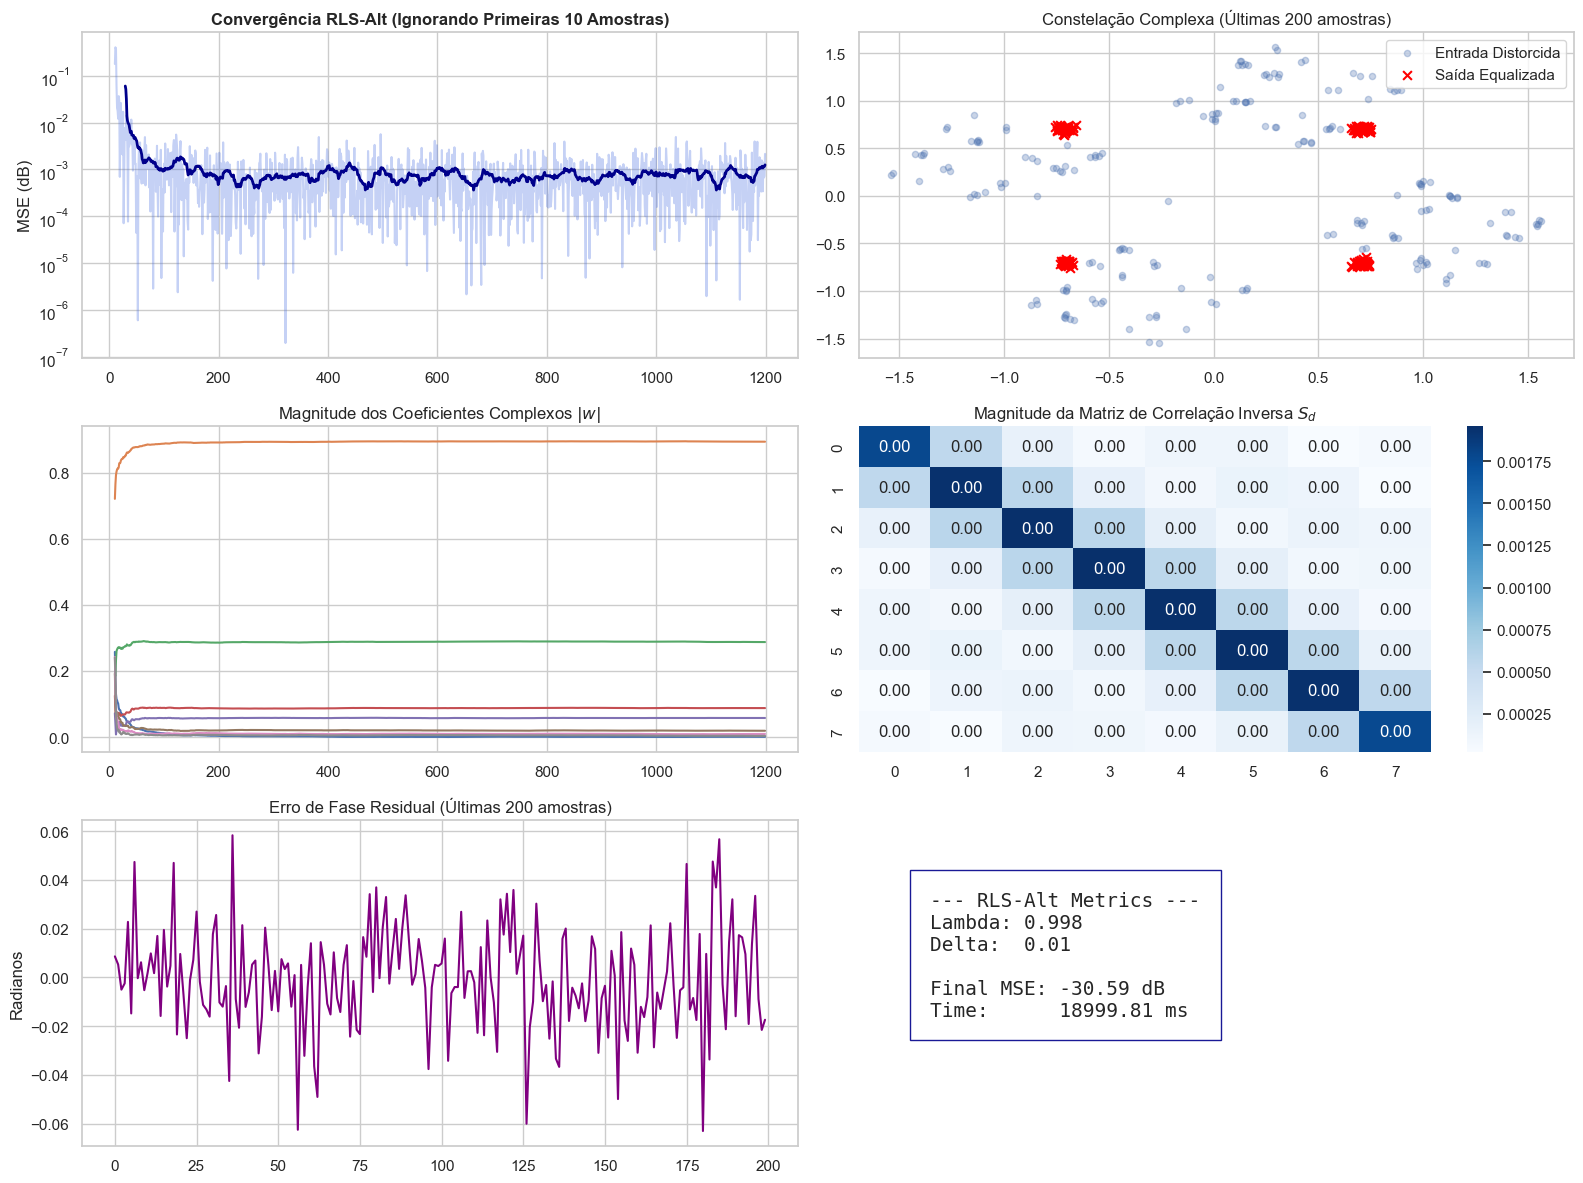

In [3]:
# --- 3. DASHBOARD DE DIAGNÓSTICO (COM TRUNCAGEM DE TRANSIENTE) ---
def plot_rls_alt_dashboard(result, offset=10):
    sns.set_theme(style="whitegrid")
    
    # Fatiamento para ignorar o transiente inicial (os 10 primeiros pontos)
    mse = result.mse()[offset:]
    err = result.errors[offset:]
    out = result.outputs[offset:]
    t = np.arange(len(result.mse()))[offset:]
    
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2)

    # A. MSE de Aprendizado
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.semilogy(t, mse, color='royalblue', alpha=0.3)
    ax1.semilogy(t, pd.Series(mse).rolling(20).mean(), color='darkblue', lw=2)
    ax1.set_title(f"Convergência RLS-Alt (Ignorando Primeiras {offset} Amostras)", fontweight='bold')
    ax1.set_ylabel("MSE (dB)")

    # B. Constelação (Antes vs Depois)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.scatter(x_distorted[-200:].real, x_distorted[-200:].imag, label='Entrada Distorcida', alpha=0.3, s=20)
    ax2.scatter(out[-200:].real, out[-200:].imag, label='Saída Equalizada', marker='x', s=40, color='red')
    ax2.set_title("Constelação Complexa (Últimas 200 amostras)")
    ax2.legend()

    # C. Evolução dos Coeficientes (Magnitude)
    ax3 = fig.add_subplot(gs[1, 0])
    coeffs = np.abs(np.array(result.coefficients)[1:])[offset:]
    ax3.plot(t, coeffs)
    ax3.set_title("Magnitude dos Coeficientes Complexos $|w|$")

    # D. Estrutura da Matriz S_d Final
    ax4 = fig.add_subplot(gs[1, 1])
    sd_final = np.abs(result.extra['S_d_last'])
    sns.heatmap(sd_final, annot=True, fmt=".2f", cmap="Blues", ax=ax4)
    ax4.set_title("Magnitude da Matriz de Correlação Inversa $S_d$")

    # E. Erro de Fase
    ax5 = fig.add_subplot(gs[2, 0])
    phase_error = np.angle(out[-200:]) - np.angle(d[-200:])
    ax5.plot(phase_error, color='purple')
    ax5.set_title("Erro de Fase Residual (Últimas 200 amostras)")
    ax5.set_ylabel("Radianos")

    # F. Info Box
    ax6 = fig.add_subplot(gs[2, 1])
    ax6.axis('off')
    time_ms = result.runtime_ms * 1000
    stats_text = (
        f"--- RLS-Alt Metrics ---\n"
        f"Lambda: {filt_alt.forgetting_factor}\n"
        f"Delta:  {filt_alt.delta}\n\n"
        f"Final MSE: {10*np.log10(np.mean(mse[-50:])):.2f} dB\n"
        f"Time:      {time_ms:.2f} ms"
    )
    ax6.text(0.1, 0.4, stats_text, fontsize=14, family='monospace', 
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='darkblue', pad=15))

    plt.tight_layout()
    plt.show()

plot_rls_alt_dashboard(result, offset=10)